# Imports & Settings

In [106]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import loguniform, uniform
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  OneHotEncoder, PolynomialFeatures, RobustScaler, StandardScaler

In [2]:
# Enable diagrams to visualize pipelines
from sklearn import set_config
set_config(display="diagram")

# Functions

In [3]:
def plot_learning_curves(model,
                         metric = "r2", cv: int = 10,
                         out: bool = False) -> None:
    """
    `out` set to True allows to export the graph in png format
    in the viz/graphs folder.
    """
    # the estimator is the pipeline's last element
    model_name = model[-1].__class__.__name__
    # in case of custom estimator, get its __name__ attribute
    try:
        metric_name = metric.__name__
    except AttributeError:
        metric_name = metric
    
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10), # 10 train sizes with cumulative 10%
        cv=cv,
        scoring=metric, # Default None. str
        n_jobs=-1,
        return_times=False # Switch if you want fit and score times
    )

    # take the mean of cross-validated train score and validation score
    # if scores are negative, take the absolute value
    train_scores_means = np.abs(np.mean(train_scores, axis=1))
    test_scores_means = np.abs(np.mean(test_scores, axis=1))

    # plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_means, label="Training Score")
    plt.plot(train_sizes, test_scores_means, label="Validation Score")
    plt.ylabel(f"{metric_name} Score", size="large", weight="bold")
    plt.xlabel("Training Set Size", size="large", weight="bold")
    plt.title(f"Learning Curves for {model_name} with {metric_name}",
              size="x-large", weight="bold", c="b")
    plt.grid(ls="--")
    plt.legend(loc="best")

    if out:
        plt.savefig(f"viz/graphs/lc_{model_name}_{metric}.png", dpi=300)
        
    plt.show()

In [4]:
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [5]:
def split_bmi_in_three(x: float) -> str:
    if x < 25:
        return "underweight_normal"
    if x < 30:
        return "overweight"
    return "obesity"

# Data Loading & Separating

In [6]:
df = pd.read_csv("csvs/cleaned_dataset.csv")

In [7]:
y = df.pop("charges")
X = df

# Preprocessing

## Modifying `y`'s Shape

<font color="orangered">**On EDA's notebook §9 was showed the target's skewness, here's to correct it.**

In [8]:
y = np.log(y + 1)

## Preprocessing 1

> 👉 <font color="orangered">**We'll scale our three numerical variables, as it is, theoretically,  > better in order to use a linear model.**</font>
>
> PS: There's still a doubt about considering or not `bmi`, which is continuous, as a nominal variable. If there's time and room to use both approaches, then it will be done later.

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


### Hold-Out 1

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    train_size=0.85,
                                                    random_state=42,
                                                    stratify=X['smoker'])

### Pipe 1

In [11]:
num_cols_1 = X.select_dtypes(exclude="object").columns
bin_cols = ["sex", "smoker"]
ohe_cols_1 = ["region"]

In [12]:
num_cols_1, bin_cols, ohe_cols_1

(Index(['age', 'bmi', 'children'], dtype='object'),
 ['sex', 'smoker'],
 ['region'])

In [13]:
preproc_1 = ColumnTransformer([
    ("num", StandardScaler(), num_cols_1),
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols_1)
])

In [14]:
preproc_1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['region'])])

## Preprocessing 2

### Bucketizing `bmi`

☝️ <font color="orangered">**First of all, we will transform `bmi` into a nominal variable.**</font>

In [15]:
X_bmi_nom = X.copy()

In [16]:
X_bmi_nom.bmi = X_bmi_nom.bmi.apply(split_bmi_in_three)
X_bmi_nom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1337 non-null   int64 
 1   sex       1337 non-null   object
 2   bmi       1337 non-null   object
 3   children  1337 non-null   int64 
 4   smoker    1337 non-null   object
 5   region    1337 non-null   object
dtypes: int64(2), object(4)
memory usage: 62.8+ KB


In [17]:
X_bmi_nom.bmi.value_counts(normalize=True)

bmi
obesity               0.528048
overweight            0.288706
underweight_normal    0.183246
Name: proportion, dtype: float64

### Holt-Out 2

In [18]:
X_bmi_nom_train, X_bmi_nom_test, y_train, y_test =\
train_test_split(X_bmi_nom, y,
                 shuffle=True,
                 train_size=0.85,
                 random_state=42,
                 stratify=X['smoker'])

In [19]:
num_cols_2 = ["age", "children"]
ohe_cols_2 = ["bmi", "region"]

In [20]:
preproc_2 = ColumnTransformer([
    ("num", StandardScaler(), num_cols_2),
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols_2)
])

In [21]:
preproc_2

ColumnTransformer(transformers=[('num', StandardScaler(), ['age', 'children']),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['bmi', 'region'])])

# Adding Estimators to End Pipelines

In [22]:
pipe_1_lr = make_pipeline(preproc_1, LinearRegression())
pipe_1_en = make_pipeline(preproc_1, ElasticNet(random_state=42))

pipe_2_lr = make_pipeline(preproc_2, LinearRegression())
pipe_2_en = make_pipeline(preproc_2, ElasticNet(random_state=42))

In [23]:
pipe_1_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('linearregression', LinearRegression())])

In [24]:
pipe_1_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('elasticnet', ElasticNet(random_state=42))])

In [25]:
pipe_2_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('linearregression', LinearRegression())])

In [26]:
pipe_2_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('elasticnet', ElasticNet(random_state=42))])

# Raw Cross-Validation

## 🚸 `StratifiedKFold` Implementation

> **MOTIVATION**
>
> We previously took care to stratify `smoker` in *test* set.
>
> We now have to take care to stratify it in *train* set too.
>
> In order to do that, we can create a `FeatureStratifiedKFold` class, based upon `StratifiedKFold`.

In [27]:
# class FeatureStratifiedKFold:
#     def __init__(self,
#                  n_splits: int = 10, shuffle: bool = True,
#                  random_state: Optional[int] = None):
#         self.n_splits = n_splits
#         self.shuffle = shuffle
#         self.random_state = random_state

#     def split(self, X, y=None):
#         stratity_by = X["smoker"]
#         sfk = StratifiedKFold(n_splits=self.n_splits, 
#                               shuffle=self.shuffle,
#                               random_state=self.random_state)
#         return skf.split(X, stratify_by)

#     def get_n_splits(self, X=None, y=None):
#         return self.n_splits

In [28]:
# feature_stratified_cv = FeatureStratifiedKFold(random_state=42)

In [29]:
def cross_val(model, X_train) -> pd.DataFrame:
    results = cross_validate(
        model,
        X_train, y_train,
        cv=10,
        scoring="r2",
        n_jobs=-1
    )
    return pd.DataFrame(results)

## `LinearRegression` with preprocessing 1

### Trainings and Results

In [30]:
%%time
cross_val(pipe_1_lr, X_train)

CPU times: user 66.6 ms, sys: 88 ms, total: 155 ms
Wall time: 1.52 s


,fit_time,score_time,test_score
0,0.020244,0.009691,0.654832
1,0.012192,0.005584,0.811772
2,0.024427,0.011875,0.769860
3,0.030872,0.012360,0.771066
4,0.021717,0.010159,0.691802
5,0.024097,0.010525,0.843344
6,0.023188,0.010436,0.727097
7,0.012608,0.005376,0.736192
8,0.018675,0.009344,0.755025
9,0.018257,0.020263,0.654486


### Score on train set

In [31]:
pipe_1_lr.fit(X_train, y_train)
pipe_1_lr.score(X_test, y_test)

0.8404852830432452

## `ElasticNet` with preprocessing 1

### Trainings and Results

In [32]:
cross_val(pipe_1_en, X_train)

,fit_time,score_time,test_score
0,0.024566,0.009038,-0.001118
1,0.018507,0.016487,-0.007625
2,0.022114,0.009493,-0.006776
3,0.019270,0.009664,-0.000694
4,0.023566,0.008759,-0.060108
5,0.021442,0.009468,-0.009554
6,0.023930,0.008747,-0.004785
7,0.016443,0.005471,-0.016696
8,0.014897,0.005082,-0.153869
9,0.013442,0.004962,-0.033521


### Score on test set

In [33]:
pipe_1_en.fit(X_train, y_train)
pipe_1_en.score(X_test, y_test)

-0.0050196621004052755

## `LinearRegression` with preprocessing 2

## Training and Results

In [34]:
cross_val(pipe_2_lr, X_bmi_nom_train)

,fit_time,score_time,test_score
0,0.018416,0.009365,0.659968
1,0.019509,0.009121,0.815449
2,0.019180,0.008801,0.772178
3,0.024395,0.007909,0.774092
4,0.019393,0.009188,0.673376
5,0.023392,0.008587,0.840828
6,0.018681,0.008639,0.734843
7,0.020311,0.008318,0.742840
8,0.011717,0.004996,0.748173
9,0.014049,0.004863,0.654622


### Score on test set

In [35]:
pipe_2_lr.fit(X_bmi_nom_train, y_train)
pipe_2_lr.score(X_bmi_nom_test, y_test)

0.8378143476270324

## `ElasticNet` with preprocessing 2

### Training and Results

In [36]:
cross_val(pipe_2_en, X_bmi_nom_train)

,fit_time,score_time,test_score
0,0.058637,0.007338,-0.001118
1,0.024806,0.011384,-0.007625
2,0.016960,0.007202,-0.006776
3,0.017777,0.007412,-0.000694
4,0.015270,0.007842,-0.060108
5,0.015648,0.005152,-0.009554
6,0.012984,0.005191,-0.004785
7,0.015724,0.007564,-0.016696
8,0.016555,0.006696,-0.153869
9,0.014652,0.004771,-0.033521


### Score on test set

In [37]:
pipe_2_en.fit(X_bmi_nom_train, y_train)
pipe_2_en.score(X_bmi_nom_test, y_test)

-0.0050196621004052755

# Full pipe

In [38]:
X_bmi_nom

,age,sex,bmi,children,smoker,region
0,19,female,overweight,0,yes,southwest
1,18,male,obesity,1,no,southeast
2,28,male,obesity,3,no,southeast
3,33,male,underweight_normal,0,no,northwest
4,32,male,overweight,0,no,northwest
...,...,...,...,...,...,...
1332,50,male,obesity,3,no,northwest
1333,18,female,obesity,0,no,northeast
1334,18,female,obesity,0,no,southeast
1335,21,female,overweight,0,no,southwest


In [39]:
ohe_cols = ["bmi", "region"]
bin_cols = ["sex", "smoker"]

In [40]:
encoder = ColumnTransformer([
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols)
], remainder="passthrough")

In [41]:
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['bmi', 'region'])])

In [123]:
poly = PolynomialFeatures(degree=2)
std = StandardScaler()
en = ElasticNet(random_state=42, max_iter=10_000, tol=1e-3)
lr = LinearRegression()

In [124]:
full_pipe_en = make_pipeline(
    encoder,
    poly,
    std,
    en
)    

In [125]:
full_pipe_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(max_iter=10000, random_state=42, tol=0.001))])

In [45]:
full_pipe_lr = make_pipeline(
    encoder,
    poly,
    std,
    lr
)    

In [46]:
full_pipe_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [126]:
params = {
    "elasticnet__alpha": loguniform(1e-5, 1),
    "elasticnet__l1_ratio": uniform(0, 1)
}

n_iter = 500

random_search = RandomizedSearchCV(
    full_pipe_en,
    param_distributions=params,
    n_iter=n_iter,
    cv=10,
    n_jobs=-1
)

random_search.fit(X_bmi_nom_train, y_train)

/home/martin/Documents/PolicyPriceAI/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e+00, tolerance: 8.441e-01
  model = cd_fast.enet_coordinate_descent(
/home/martin/Documents/PolicyPriceAI/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e+00, tolerance: 8.570e-01
  model = cd_fast.enet_coordinate_descent(
/home/martin/Documents/PolicyPriceAI/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('bin',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['bmi',
                                                                                'region'])])),
                                             ('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('elasticnet',
                                              ElasticNet(max_iter=10000,
                                                         random_state=42,
                                                         tol=0.001))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'elasticnet__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dd603b580>,
                                        'elasticnet__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dd603af20>})

In [49]:
%%time
cross_val(full_pipe_lr, X_bmi_nom_train)

CPU times: user 34.7 ms, sys: 2.78 ms, total: 37.5 ms
Wall time: 83 ms


,fit_time,score_time,test_score
0,0.021212,0.008107,0.734750
1,0.020719,0.008351,0.874086
2,0.020930,0.007975,0.815013
3,0.021321,0.007998,0.851296
4,0.022502,0.007876,0.739207
5,0.021926,0.008118,0.907669
6,0.021651,0.007554,0.838420
7,0.030267,0.005618,0.797334
8,0.017774,0.006315,0.840284
9,0.016808,0.008357,0.735789


In [50]:
full_pipe_lr.fit(X_bmi_nom_train, y_train)
full_pipe_lr.score(X_bmi_nom_test, y_test)

0.9152787720895623

In [88]:
coefs = full_pipe_lr[-1].coef_
# coefs

In [89]:
feats = full_pipe_lr[:-1].get_feature_names_out()
# feats

In [83]:
scores = {feat: coef for feat, coef in zip(feats, coefs)}
# scores

In [82]:
(pd.DataFrame(scores, index=["coef"])
 .T
 .sort_values(by="coef", key=lambda x: abs(x), ascending=False)
)

,coef
ohe__bmi_overweight^2,-3.726059e+12
ohe__bmi_overweight,3.726059e+12
bin__smoker_yes,2.561632e+12
bin__smoker_yes^2,-2.561632e+12
ohe__region_southwest^2,-2.311479e+12
ohe__region_southwest,2.311479e+12
bin__sex_male^2,-1.360072e+12
bin__sex_male,1.360072e+12
ohe__region_northwest,-2.915813e+11
ohe__region_northwest^2,2.915813e+11


## Residuals

In [114]:
y_train_pred = full_pipe_lr.predict(X_bmi_nom_train)

residuals = y_train - y_train_pred
residuals

1094   -0.407678
94      0.183753
349    -0.240675
410    -0.284420
981    -0.221155
          ...   
674    -0.037092
752    -0.233413
319    -0.220139
934    -0.118232
1113   -0.158400
Name: charges, Length: 1136, dtype: float64

### Residuals Distribution

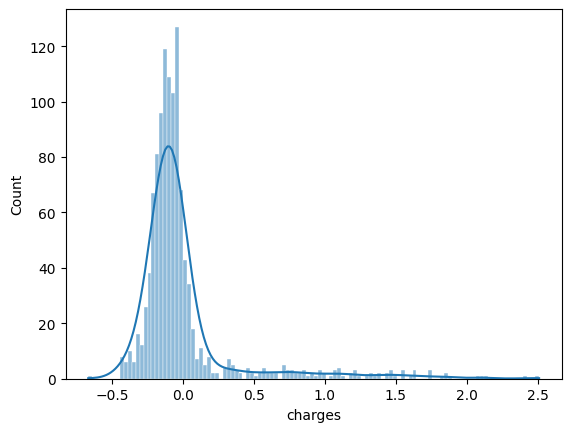

In [103]:
sns.histplot(residuals, kde=True, edgecolor="w")
plt.show()

<font color="orangered">**It seems the residuals are not normally distributed.**</font>

### Residuals vs Fitted

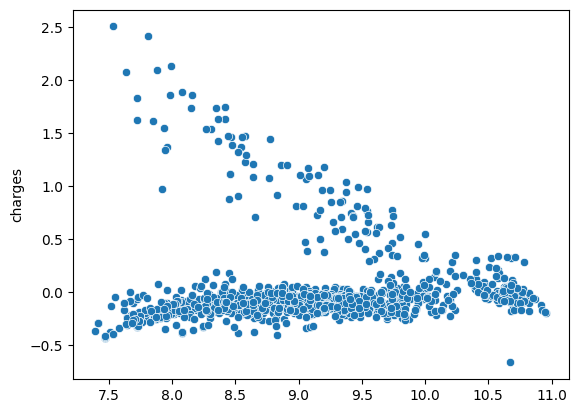

In [104]:
sns.scatterplot(x=y_train_pred, y=residuals)
plt.show()

<font color="orangered">**They don't seem to be of equal variance.**</font>

# Robust Scaling

## Training

In [108]:
rob = RobustScaler()

In [109]:
rob_pipe_lr = make_pipeline(
    encoder,
    poly,
    rob,
    lr
)    

In [110]:
rob_pipe_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [111]:
%%time
cross_val(rob_pipe_lr, X_bmi_nom_train)

CPU times: user 67.7 ms, sys: 121 ms, total: 189 ms
Wall time: 1.54 s


,fit_time,score_time,test_score
0,0.043829,0.008441,0.733168
1,0.086186,0.017410,0.873848
2,0.040902,0.008801,0.817529
3,0.034987,0.006001,0.852948
4,0.034337,0.005983,0.740656
5,0.045388,0.008595,0.910733
6,0.044989,0.008651,0.839681
7,0.042198,0.008324,0.804394
8,0.039158,0.008661,0.842495
9,0.038498,0.008087,0.736842


## Score

In [112]:
rob_pipe_lr.fit(X_bmi_nom_train, y_train)
rob_pipe_lr.score(X_bmi_nom_test, y_test)

0.9179762041725034

## Residuals

In [115]:
y_train_pred = rob_pipe_lr.predict(X_bmi_nom_train)

residuals = y_train - y_train_pred
residuals

1094   -0.406142
94      0.150314
349    -0.243671
410    -0.258529
981    -0.184955
          ...   
674    -0.016570
752    -0.210304
319    -0.211596
934    -0.145413
1113   -0.137979
Name: charges, Length: 1136, dtype: float64

### Residuals Distribution

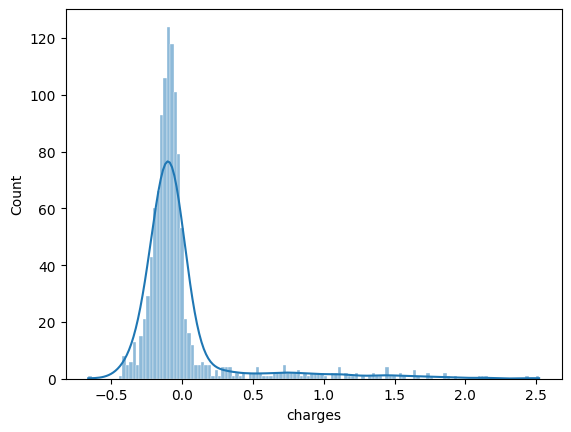

In [116]:
sns.histplot(residuals, kde=True, edgecolor="w")
plt.show()

### Residuals vs Fitted

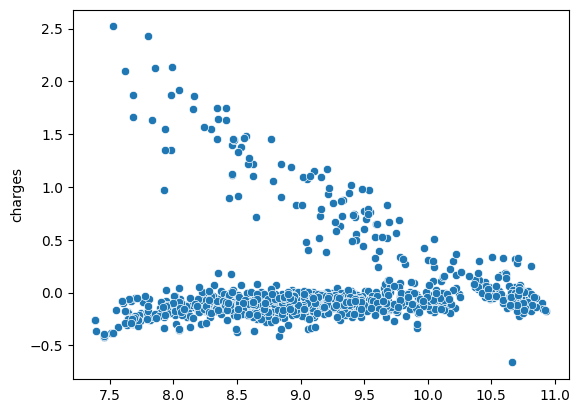

In [117]:
sns.scatterplot(x=y_train_pred, y=residuals)
plt.show()

<font color="orangered">**It seems using `RobustScaler` didn't solve heteroscedasticity.**</font>